###Temperature Prediction Using IoT Sensor Data
The data used in this notebook model consists of temperature readings collected from IoT temperature sensors. The primary purpose of this model is to predict future temperature values based on historical data. This is achieved by training a Long Short-Term Memory (LSTM) neural network, that contains **Two LSTM Layer** which is particularly well-suited for time series forecasting due to its ability to capture temporal dependencies.

In [1]:
#Adding neccessary python packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ModelCheckpoint
import keras
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
mode='colab'
#mode='local'
learning_rate=0.01
opt = keras.optimizers.Adam(learning_rate)
Epochs=20

###Data Loading

In [3]:
#Set local system or colab if using google colaboratory
from google.colab import drive
if mode=='colab':
  drive.mount('/content/drive')
  # Load dataset
  data = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/0_Temperature_Prediction/IOT-temp.csv')
else:
  data = pd.read_csv('IOT-temp.csv')

Mounted at /content/drive


###Data Details and visulaiztion

In [4]:
# Display basic information and check for missing values
print(data.info())
print(data.describe())

# Plot temperature over time
#plt.plot(data['temp'], data['noted_date'])
#plt.xlabel('Time')
#plt.ylabel('Temperature')
#plt.title('Temperature Over Time')
#plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97606 entries, 0 to 97605
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          97606 non-null  object
 1   room_id/id  97606 non-null  object
 2   noted_date  97606 non-null  object
 3   temp        97606 non-null  int64 
 4   out/in      97606 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.7+ MB
None
               temp
count  97606.000000
mean      35.053931
std        5.699825
min       21.000000
25%       30.000000
50%       35.000000
75%       40.000000
max       51.000000


In [5]:
print(data.head())

                                    id  room_id/id        noted_date  temp  \
0  __export__.temp_log_196134_bd201015  Room Admin  08-12-2018 09:30    29   
1  __export__.temp_log_196131_7bca51bc  Room Admin  08-12-2018 09:30    29   
2  __export__.temp_log_196127_522915e3  Room Admin  08-12-2018 09:29    41   
3  __export__.temp_log_196128_be0919cf  Room Admin  08-12-2018 09:29    41   
4  __export__.temp_log_196126_d30b72fb  Room Admin  08-12-2018 09:29    31   

  out/in  
0     In  
1     In  
2    Out  
3    Out  
4     In  


#Pre-Processing/Data Preperation

###Remving Duplicates

The sensor data, shows two entries for each time, i.e., date_noted. And for both entries the time and the temperature are same. So we need to remove them and take only unique time and temperature.

In [6]:
# Create a new DataFrame with unique timestamps and their corresponding temperatures
unique_data = data.drop_duplicates(subset=['noted_date'], keep='first')

# Print the shape of the original and new DataFrames to see the difference
print(f"Original data shape: {data.shape}")
print(f"Unique data shape: {unique_data.shape}")
print(unique_data.head())
unique_data.to_csv('unique_temperatures.csv', index=False)  # Save to CSV if needed

Original data shape: (97606, 5)
Unique data shape: (27920, 5)
                                     id  room_id/id        noted_date  temp  \
0   __export__.temp_log_196134_bd201015  Room Admin  08-12-2018 09:30    29   
2   __export__.temp_log_196127_522915e3  Room Admin  08-12-2018 09:29    41   
6   __export__.temp_log_196121_01544d45  Room Admin  08-12-2018 09:28    29   
8   __export__.temp_log_196111_6b7a0848  Room Admin  08-12-2018 09:26    29   
10  __export__.temp_log_196108_4a983c7e  Room Admin  08-12-2018 09:25    42   

   out/in  
0      In  
2     Out  
6      In  
8      In  
10    Out  


The data is to be reversed, becuase the time is to be in increasing order. Future prediction will be based on the last minutes temperature. Say T3, T2, T1. So better to reverse the order, It makes good sense.

In [7]:
#Check the reversing order
print('Actual Sequence:',unique_data['temp'], 'Reversed Sequence:',np.flip(unique_data['temp']))

Actual Sequence: 0        29
2        41
6        29
8        29
10       42
         ..
97568    31
97569    32
97571    31
97576    31
97603    31
Name: temp, Length: 27920, dtype: int64 Reversed Sequence: 97603    31
97576    31
97571    31
97569    32
97568    31
         ..
10       42
8        29
6        29
2        41
0        29
Name: temp, Length: 27920, dtype: int64


In [8]:
Temp=np.flip(unique_data['temp'])
print(Temp.shape)

(27920,)


###Handling Missing Values

In [9]:
# Handling missing values (if any)
Temp.interpolate(method='linear', inplace=True)

###Data Normalization, to make it of same range. For better learning.

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Scaling temperature data to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_temperature = scaler.fit_transform(Temp.values.reshape(-1, 1))

Use this if needed, For similicity, Lets suppose we do not split, and just focus on training accuracy.

In [11]:
# Split the data into training and testing sets
#train_size = int(len(scaled_temperature) * 0.8)
#test_size = len(scaled_temperature) - train_size
#train_data = scaled_temperature[0:train_size]
#test_data = scaled_temperature[train_size:len(scaled_temperature)]

In time series forecasting, especially when using models like LSTMs, GRUs, or other sequence-based models, **`n_steps_in`** and **`n_steps_out`** refer to the number of time steps used for input (past data) and output (future predictions), respectively.

### Definitions with 10 steps:

1. **`n_steps_in = 10` (Input Sequence Length)**:
   - This means the model will look at the last 10 time steps (or data points) from the past to make predictions about the future.
   - Example: If `n_steps_in = 10`, the model uses data from the last 10 minutes (or 10 time steps, depending on your data frequency).

2. **`n_steps_out = 10` (Output Sequence Length)**:
   - This means the model will predict the next 10 time steps based on the input sequence.
   - Example: If `n_steps_out = 10`, the model predicts the temperature for the next 10 minutes (or time steps).

### Example for `n_steps_in = 10` and `n_steps_out = 10`:

Assume you have temperature data for every minute, and you want to predict the next 10 minutes based on the last 10 minutes of data. Here:
- **`n_steps_in = 10`**: The model looks at data from the last 10 minutes.
- **`n_steps_out = 10`**: The model predicts the temperature for the next 10 minutes.

### Sliding Window Approach with 10 Steps:
The data is structured into input-output pairs:
- Input (`n_steps_in = 10`) → Output (`n_steps_out = 10`).

For example, if you have temperature data like `[t1, t2, t3, ..., tn]`:
- For the first window: `[t1, t2, ..., t10]` → `[t11, t12, ..., t20]`.
- For the next window, the sequence moves forward by one step: `[t2, t3, ..., t11]` → `[t12, t13, ..., t21]`.

This helps train the model to predict the temperature for the next 10 time steps based on the previous 10 time steps of data.

In [12]:
n_steps_in = 10  # Last 10 minutes as input
n_steps_out = 10  # Predict next 10 minutes

# Prepare input/output sequences
X, y = [], []
for i in range(len(scaled_temperature) - n_steps_in - n_steps_out + 1):
    X.append(scaled_temperature[i:i + n_steps_in])
    y.append(scaled_temperature[i + n_steps_in:i + n_steps_in + n_steps_out])

X, y = np.array(X), np.array(y)

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

In [13]:
print(X.shape)
print(y.shape)

(27901, 10, 1)
(27901, 10, 1)


In [14]:
# prompt: rewrite lstm_model with 2 lstm layers

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(n_steps_in, 1)))  # First LSTM layer
lstm_model.add(LSTM(50))  # Second LSTM layer
lstm_model.add(Dense(n_steps_out))
lstm_model.compile(loss='mean_squared_error', optimizer=opt)
# Define the ModelCheckpoint callback to save the best model based on validation loss
checkpoint = ModelCheckpoint('Temperature_predictor.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
history=lstm_model.fit(X, y, epochs=Epochs, batch_size=32, callbacks=[checkpoint])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


872/872 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0241
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


872/872 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.0193
Epoch 3/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0194
Epoch 4/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0194
Epoch 5/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0194
Epoch 6/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0190
Epoch 7/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0189
Epoch 8/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0189
Epoch 9/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0189
Epoch 10/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0187
Epoch 11/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0186
Epoch 12/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0189
Epoch 13/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.0188
Epoch 14/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0187
Epoch 15/20
872/872 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0185
Epoch 16/20
872/872 ━━━━━━━━━━━━━━━━━━━

###Saving Model Weights

In [15]:
lstm_model.save('Temperature_predictor.keras')
#lstm_model.load('Temperature_predictor.keras')

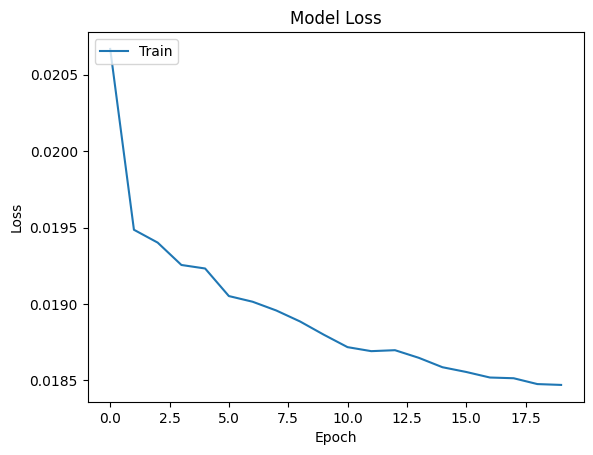

<Figure size 640x480 with 0 Axes>

In [16]:
# Plot history of the model using matplotlib

import matplotlib.pyplot as plt
# Plot training history
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

###EValuate Model on X

In [17]:
# Evaluate the baseline model
predictions = lstm_model.predict(X)

872/872 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [18]:
print(predictions.shape)

(27901, 10)


In [19]:
#Flattening for MSE
y_flattened = y.flatten()
predictions_flattened = predictions.flatten()

print(f"Shape of flattened y: {y_flattened.shape}")
print(f"Shape of flattened predictions: {predictions_flattened.shape}")

Shape of flattened y: (279010,)
Shape of flattened predictions: (279010,)


In [20]:
#Find the mean squared error between y and predictions

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_flattened, predictions_flattened)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.018354349885327137


###Pick the last temperature window, and predict future next, Reverse transform

In [24]:
#print last prediction index
predicted_temperature = scaler.inverse_transform(predictions[-1].reshape(-1, 1))
print('Next 10 days temperature using previous 10 days: ',predicted_temperature)

Next 10 days temperature using previous 10 days:  [[35.255928]
 [34.265347]
 [35.392387]
 [34.91508 ]
 [35.83675 ]
 [35.019127]
 [34.82255 ]
 [35.330982]
 [35.35399 ]
 [35.6252  ]]


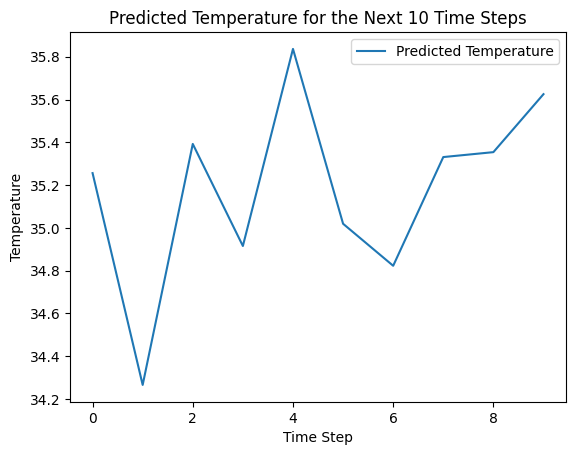

In [25]:
#plot predicted temperature

import matplotlib.pyplot as plt
# Plot the predicted temperature
plt.plot(predicted_temperature, label='Predicted Temperature')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.title('Predicted Temperature for the Next 10 Time Steps')
plt.legend()
plt.show()